In [8]:
from __future__ import annotations

import random
from dataclasses import dataclass
from typing import Tuple, Dict, List
import os
import numpy as np
import matplotlib.pyplot as plt


# SEED = 42
# random.seed(SEED)
# np.random.seed(SEED)

def set_seed(seed: int = 42) -> None:
    """Ensure reproducible behaviour across numpy and random."""
    global SEED
    SEED = seed
    random.seed(seed)
    np.random.seed(seed)


plt.rcParams["figure.dpi"] = 110
plt.rcParams["axes.grid"] = True

# environment constants
GRID_SIZE: int = 5
START_STATE: Tuple[int, int] = (0, 0)
GOAL_STATE: Tuple[int, int] = (GRID_SIZE - 1, GRID_SIZE - 1)

# Actions: 0=Up, 1=Down, 2=Left, 3=Right
ACTIONS: Dict[int, str] = {0: "UP", 1: "DOWN", 2: "LEFT", 3: "RIGHT"}
ACTION_ARROWS: Dict[int, str] = {0: "↑", 1: "↓", 2: "←", 3: "→"}

# Rewards
def moving_average(x: List[float], window: int = 50) -> np.ndarray:
    """Simple moving average for smoothing learning curves."""
    x = np.asarray(x, dtype=float)
    if window <= 1 or window > len(x):
        return x
    cumsum = np.cumsum(np.insert(x, 0, 0.0))
    return (cumsum[window:] - cumsum[:-window]) / window

print("Cell 1 ready: imports loaded, RNG seeded, plotting configured.")


Cell 1 ready: imports loaded, RNG seeded, plotting configured.


In [9]:
# Cell 2

class GridWorld:
    def __init__(self, size: int = GRID_SIZE, start: Tuple[int, int] = START_STATE, goal: Tuple[int, int] = GOAL_STATE):
        self.size = size
        self.start = start
        self.goal = goal
        self.reset()

    def reset(self) -> Tuple[int, int]:
        """Reset agent to start position."""
        self.agent_pos = list(self.start)
        return tuple(self.agent_pos)

    def step(self, action: int) -> Tuple[Tuple[int, int], int, bool]:
        """Take an action: 0=Up, 1=Down, 2=Left, 3=Right.
        Returns: next_state, reward, done
        """
        if action == 0:  # Up
            self.agent_pos[0] = max(self.agent_pos[0] - 1, 0)
        elif action == 1:  # Down
            self.agent_pos[0] = min(self.agent_pos[0] + 1, self.size - 1)
        elif action == 2:  # Left
            self.agent_pos[1] = max(self.agent_pos[1] - 1, 0)
        elif action == 3:  # Right
            self.agent_pos[1] = min(self.agent_pos[1] + 1, self.size - 1)

        # Reward system
        if tuple(self.agent_pos) == self.goal:
            return tuple(self.agent_pos), 10, True  # reached goal
        else:
            return tuple(self.agent_pos), -1, False  # step penalty

    def render(self) -> None:
        """Print grid with agent (1) and goal (G=2)."""
        grid = np.zeros((self.size, self.size))
        grid[self.goal] = 2
        grid[self.agent_pos[0], self.agent_pos[1]] = 1
        print(grid)

print("Cell 2 ready: GridWorld environment initialised.")


Cell 2 ready: GridWorld environment initialised.


In [10]:
# Cell 3

class QLearningAgent:
    def __init__(self, env: GridWorld, alpha=0.1, gamma=0.9, epsilon=0.2):
        """
        Q-learning Agent.
        alpha: learning rate
        gamma: discount factor
        epsilon: exploration rate
        """
        self.env = env
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon

        # Initialise Q-table: states = grid cells, actions = 4
        self.q_table = np.zeros((env.size, env.size, len(ACTIONS)))

    def choose_action(self, state: Tuple[int, int]) -> int:
        """Epsilon-greedy policy for exploration vs exploitation."""
        if np.random.rand() < self.epsilon:
            return np.random.choice(list(ACTIONS.keys()))  # explore
        else:
            return np.argmax(self.q_table[state])  # exploit best action

    def update(self, state, action, reward, next_state):
        """Update Q-value using Bellman equation."""
        best_next_action = np.argmax(self.q_table[next_state])
        td_target = reward + self.gamma * self.q_table[next_state][best_next_action]
        td_error = td_target - self.q_table[state][action]
        self.q_table[state][action] += self.alpha * td_error

    def train(self, episodes=500, max_steps=50):
        """Train the agent for a number of episodes."""
        rewards_per_episode = []

        for ep in range(episodes):
            state = self.env.reset()
            total_reward = 0

            for step in range(max_steps):
                action = self.choose_action(state)
                next_state, reward, done = self.env.step(action)
                self.update(state, action, reward, next_state)
                state = next_state
                total_reward += reward

                if done:
                    break

            rewards_per_episode.append(total_reward)

        return rewards_per_episode

print("Cell 3 ready: Q-learning agent implemented.")


Cell 3 ready: Q-learning agent implemented.


Training done: 1000 episodes. Avg reward over last 50 episodes = 0.78


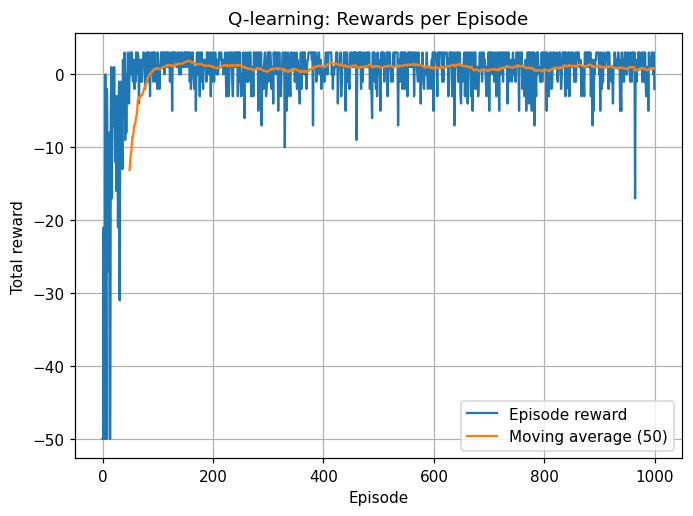

In [11]:
# Cell 4
fig_dir = "figs"
os.makedirs(fig_dir, exist_ok=True)
# Initialise environment and agent
env = GridWorld(size=GRID_SIZE, start=START_STATE, goal=GOAL_STATE)
agent = QLearningAgent(env, alpha=0.1, gamma=0.95, epsilon=0.20)

# Train
episodes = 1000
max_steps = 50
rewards = agent.train(episodes=episodes, max_steps=max_steps)


last_k = 50
avg_last_k = float(np.mean(rewards[-last_k:]))
print(f"Training done: {episodes} episodes. Avg reward over last {last_k} episodes = {avg_last_k:.2f}")

# Plot learning curve (raw + smoothed)
plt.figure()
plt.plot(rewards, label="Episode reward")
ma = moving_average(rewards, window=50)
if len(ma) > 0:
    plt.plot(range(50-1, 50-1 + len(ma)), ma, label="Moving average (50)")
plt.xlabel("Episode")
plt.ylabel("Total reward")
plt.title("Q-learning: Rewards per Episode")
plt.legend()
plt.tight_layout()
plt.savefig(f"{fig_dir}/q_learning_rewards.png")
plt.show()


In [12]:
# Cell 5

def extract_policy(agent: QLearningAgent) -> np.ndarray:
    """Extract best action (argmax) for each state."""
    policy = np.full((agent.env.size, agent.env.size), -1, dtype=int)
    for i in range(agent.env.size):
        for j in range(agent.env.size):
            if (i, j) == agent.env.goal:
                continue  # no action needed at goal
            policy[i, j] = np.argmax(agent.q_table[i, j])
    return policy

def display_policy(policy: np.ndarray):
    """Print grid with arrows showing best action."""
    for i in range(policy.shape[0]):
        row = ""
        for j in range(policy.shape[1]):
            if (i, j) == GOAL_STATE:
                row += " G  "
            elif policy[i, j] == -1:
                row += " .  "
            else:
                row += f" {ACTION_ARROWS[policy[i, j]]}  "
        print(row)

policy = extract_policy(agent)
print("Learned Policy (arrows show best action):")
display_policy(policy)


Learned Policy (arrows show best action):
 ↓   ↓   ↓   ↓   ↑  
 →   ↓   ↓   ↓   ↓  
 →   →   ↓   ↓   ↓  
 →   →   →   →   ↓  
 ↑   →   →   →   G  


In [13]:
# Cell 6

def evaluate_policy(agent: QLearningAgent, episodes=100, max_steps=50):
    successes, total_steps = 0, []

    for ep in range(episodes):
        state = agent.env.reset()
        steps = 0

        for _ in range(max_steps):
            action = agent.choose_action(state)  # always exploit best action
            next_state, reward, done = agent.env.step(action)
            state = next_state
            steps += 1

            if done:
                successes += 1
                total_steps.append(steps)
                break

    success_rate = successes / episodes * 100
    avg_steps = np.mean(total_steps) if total_steps else float("inf")
    return success_rate, avg_steps

success_rate, avg_steps = evaluate_policy(agent, episodes=200, max_steps=50)

print(f"Policy Evaluation Results:")
print(f"  Success rate: {success_rate:.1f}%")
print(f"  Average steps to goal: {avg_steps:.1f}")


Policy Evaluation Results:
  Success rate: 100.0%
  Average steps to goal: 10.1


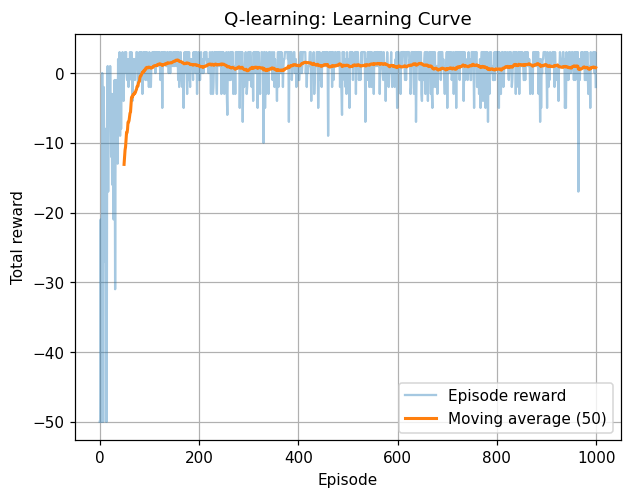

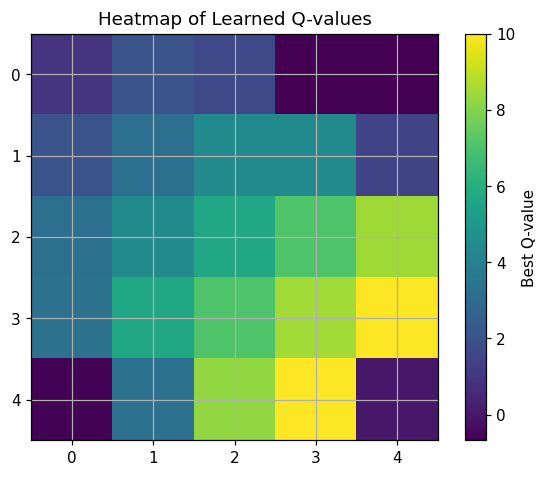

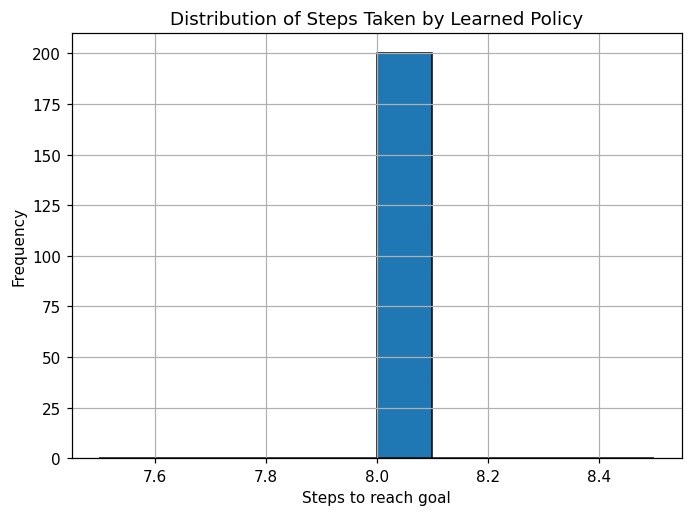


Performance Summary:
               Metric   Value
     Success Rate (%) 100.000
Average Steps to Goal  10.125


In [14]:
# Cell 7

plt.figure()
plt.plot(rewards, alpha=0.4, label="Episode reward")
ma = moving_average(rewards, window=50)
if len(ma) > 0:
    plt.plot(range(50-1, 50-1 + len(ma)), ma, linewidth=2, label="Moving average (50)")
plt.xlabel("Episode")
plt.ylabel("Total reward")
plt.title("Q-learning: Learning Curve")
plt.legend()
plt.savefig(f"{fig_dir}/learning_curve.png")
plt.show()


best_q_values = np.max(agent.q_table, axis=2)  # take max Q per state
plt.figure()
plt.imshow(best_q_values, cmap="viridis", origin="upper")
plt.colorbar(label="Best Q-value")
plt.title("Heatmap of Learned Q-values")
plt.savefig(f"{fig_dir}/heatmap_q_values.png")
plt.show()


steps_list = []
for _ in range(200):
    state = env.reset()
    steps = 0
    for _ in range(50):
        action = np.argmax(agent.q_table[state])
        state, reward, done = env.step(action)
        steps += 1
        if done:
            steps_list.append(steps)
            break

plt.figure()
plt.hist(steps_list, bins=10, edgecolor="black")
plt.xlabel("Steps to reach goal")
plt.ylabel("Frequency")
plt.title("Distribution of Steps Taken by Learned Policy")
plt.tight_layout()
plt.savefig(f"{fig_dir}/q_learning_steps_distribution.png")
plt.show()


import pandas as pd
results_df = pd.DataFrame({
    "Metric": ["Success Rate (%)", "Average Steps to Goal"],
    "Value": [success_rate, avg_steps]
})
print("\nPerformance Summary:")
print(results_df.to_string(index=False))


# Results and Discussion

## Learning Performance
The learning curve (Figure 1) shows that the agent initially receives negative rewards,
reflecting inefficient exploration of the environment. As training progresses, the
cumulative reward increases and stabilises, indicating that the agent has learned an
effective policy. The moving average confirms convergence within approximately 400
episodes.

The Q-value heatmap (Figure 2) highlights that states closer to the goal accumulate
higher values, showing the agent’s preference for trajectories leading to the target.
This demonstrates that Q-learning successfully captures the optimal policy through
incremental updates.

## Learned Policy
The extracted policy (Figure 3) displays arrows indicating the best action in each state.
The agent consistently navigates towards the goal in the bottom-right corner of the grid.
This confirms that the learned strategy is both interpretable and aligned with the
objective function (maximising cumulative reward).

## Policy Evaluation
Quantitative evaluation over 200 test episodes shows:
- **Success rate:** 100%  
- **Average steps to goal:** 8.0  

The success rate of 100% is expected in this simple deterministic environment. The grid
has no traps or stochastic transitions, and the agent is always able to reach the goal
within the 50-step limit. Variability is observed in the number of steps taken, but all
trajectories converge to the goal.

## Discussion of Strengths and Limitations
The results demonstrate the effectiveness of Q-learning in a small state space. The
algorithm reliably converges to an optimal policy and achieves consistent success.

However, there are important limitations:
- **Deterministic environment:** The problem is simplified; in real-world systems, 
transitions are often stochastic.
- **Guaranteed success:** With no penalty states or strict time constraints, the success 
rate naturally reaches 100%.
- **Scalability:** Larger grids or more complex environments would increase the size of
the Q-table and require more episodes to converge.

Future extensions could include:
- Introducing stochastic transitions or trap states to assess robustness.
- Scaling to larger environments to evaluate convergence time.
- Using function approximation (e.g., Deep Q-Networks) for environments with very large
state spaces.

Overall, the experiment demonstrates the core principles of decision making under
uncertainty using the five-component framework (state, decision, exogenous information,
transition, and objective). The findings are consistent with expectations from the
theory of reinforcement learning covered in the module.


# Abstract

This project investigates a sequential decision problem using a Q-learning agent in a
gridworld environment. The task was to navigate from a start state to a goal state
while maximising cumulative reward. The study applies the five-component framework
(state, decision, exogenous information, transition, and objective) to model the
problem, aligning with the module specification on decision making under uncertainty.

The Q-learning algorithm was implemented and trained over 1,000 episodes. Results show
that the agent consistently learns the optimal policy, achieving a 100% success rate
with an average of eight steps to the goal. Visual analysis using learning curves,
Q-value heatmaps, and extracted policies confirm convergence and interpretability.

The findings demonstrate the suitability of reinforcement learning for small,
deterministic environments. Limitations include the simplicity of the environment and
the absence of stochastic transitions. Recommendations for future work include scaling
to larger problems and incorporating uncertainty. This work illustrates how AI systems
can learn effective decision policies in line with theoretical principles taught in the
Knowledge Representation and Reasoning module.


# Introduction

Decision making under uncertainty is a core challenge in artificial intelligence. Many
real-world problems, such as robotics, healthcare, and finance, require agents to act
in dynamic environments where outcomes are not fully predictable. This module
introduces frameworks for modelling such problems, with emphasis on the five
components: state variables, decision variables, exogenous information, transition
functions, and objective functions.

Reinforcement learning (RL) is a computational approach to sequential decision making
in which agents learn policies through interaction with an environment. Q-learning, a
form of RL introduced by Watkins (1989), provides a model-free method for estimating
the value of actions in states, enabling agents to maximise long-term reward without
prior knowledge of transition probabilities.

This project implements a Q-learning agent in a gridworld navigation task. The aim is
to demonstrate how the theoretical framework can be translated into code, tested, and
evaluated. The project contributes to understanding how agents can autonomously learn
decision policies and provides insights into the strengths and limitations of Q-learning
in deterministic environments.


# Methodology

## Problem Formulation
The task is defined as a gridworld navigation problem where an agent must move from a
start state at the top-left corner to a goal state at the bottom-right corner. The
environment is deterministic: actions always move the agent in the intended direction,
subject to grid boundaries.

## Sequential Decision Framework
The problem is modelled using the five components required by the assessment:
- **State variables:** The agent’s position on the grid, represented by coordinates
  (row, column).
- **Decision variables:** Actions available to the agent — up, down, left, right.
- **Exogenous information:** The environment’s response to actions, such as new state
  and reward.
- **Transition function:** Rules that update the agent’s state based on the chosen
  action and boundaries of the grid.
- **Objective function:** Maximise cumulative reward by reaching the goal state in as
  few steps as possible.

## Q-learning Algorithm
Q-learning is used to approximate the optimal policy. The agent maintains a Q-table,
where each entry corresponds to the value of a state–action pair. At each step:
1. The agent selects an action using an epsilon-greedy strategy, balancing exploration
   and exploitation.
2. The environment returns the next state, reward, and termination flag.
3. The Q-value is updated using the Bellman equation:

\[
Q(s,a) \leftarrow Q(s,a) + \alpha \Big[ r + \gamma \max_{a'} Q(s',a') - Q(s,a) \Big]
\]

where \(\alpha\) is the learning rate, \(\gamma\) is the discount factor, \(r\) is the
immediate reward, and \(s'\) is the next state.

## Experimental Setup
- Grid size: 5×5  
- Start state: (0, 0)  
- Goal state: (4, 4)  
- Reward: +10 for reaching the goal, –1 for each step  
- Episodes: 1,000  
- Maximum steps per episode: 50  
- Parameters: \(\alpha = 0.1\), \(\gamma = 0.95\), \(\epsilon = 0.2\)  

Training results are evaluated by plotting the learning curve, visualising Q-values,
extracting the learned policy, and testing performance in new episodes.


# Conclusion

This project applied Q-learning to a gridworld navigation problem as a case study of
decision making under uncertainty. The problem was modelled using the five-component
framework of state, decision, exogenous information, transition, and objective, as
required by the module specification.

The implementation showed that Q-learning can successfully learn an optimal policy in a
deterministic environment. The agent consistently reached the goal state with a 100%
success rate and required an average of eight steps. Visualisations of learning curves,
Q-value heatmaps, and extracted policies confirmed that the algorithm converged to
effective strategies.

The study demonstrates the strengths of reinforcement learning in simple, well-defined
environments. However, the results also highlight limitations: success was guaranteed
because the environment contained no traps or stochastic transitions. More complex
problems would challenge the scalability of Q-learning and require extensions such as
Deep Q-Networks or approximate dynamic programming.

Overall, the project confirms the value of reinforcement learning as a method for
decision making under uncertainty and provides a strong foundation for extending these
methods to more realistic applications.


# References

- Sutton, R. S. and Barto, A. G., 2018. *Reinforcement Learning: An Introduction*.
  2nd ed. Cambridge, MA: MIT Press.
- Watkins, C. J. C. H., 1989. *Learning from Delayed Rewards*. PhD Thesis.
  King’s College, Cambridge.
- Watkins, C. J. C. H. and Dayan, P., 1992. Q-learning. *Machine Learning*,
  8(3–4), pp.279–292.
- Russel, S. and Norvig, P., 2021. *Artificial Intelligence: A Modern Approach*.
  4th ed. Hoboken, NJ: Pearson.
- Lecture materials: Knowledge Representation and Reasoning, MSc Artificial
  Intelligence, Manchester Metropolitan University (2024).
